# BG-NBD ve Gamma-Gamma ile CLTV Tahmini

## CLTV (Customer Lifetime Value) 
### Nedir ? 
* Bir müşterinin işletmeye sağladığı tahmini toplam finansel değeri ölçen bir metriktir
### Niye kullanılır ?
* Müşteri segmentasyonu, pazarlama stratejileri ve gelir optimizasyonu için müşteri bazlı değer tahmini yapmak amacıyla kullanılır.
### CLTV değerini bulabilmek için hangi yöntemler kullanılır ? Niye kullanılır ?
* BG-NBD modeli müşteri alışveriş davranışlarını tahmin ederken, Gamma-Gamma modeli müşteri başına düşen harcama tutarını belirleyerek daha doğru bir CLTV tahmini yapılmasını sağlar.
    * BG-NBD(Beta Geometric/Negative Binomial Distribution) : Müşterinin tekrar alışveriş yapma olasılığını ve satın alma sıklığını tahmin eden olasılık tabanlı bir modeldir.
    * Gamma - Gamma : Müşterilerin satın alma başına ortalama harcama tutarını tahmin eden bir gelir modelidir.

## İş Problemi
* Türkiyede önde gelen ayakkabı online satış mağazası, satış ve pazarlama faaliyetleri için roadmap belirlemek istemektedir. Şirketin orta uzun vadeli plan yapabilmesi için var olan müşterilerin gelecekte şirkete sağlayacakları potansiyel değerin tahmin edilmesi gerekmektedir.

## Veri Seti Hikayesi
* Veri seti, şirketten son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan) olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

## Değişkenler
* master_id: Eşsiz müşteri numarası
* order_channel : Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile, Offline)
* last_order_channel : En son alışverişin yapıldığı kanal
* first_order_date : Müşterinin yaptığı ilk alışveriş tarihi
* last_order_date : Müşterinin yaptığı son alışveriş tarihi
* last_order_date_online : Muşterinin online platformda yaptığı son alışveriş tarihi
* last_order_date_offline : Muşterinin offline platformda yaptığı son alışveriş tarihi
* order_num_total_ever_online : Müşterinin online platformda yaptığı toplam alışveriş sayısı
* order_num_total_ever_offline : Müşterinin offline'da yaptığı toplam alışveriş sayısı
* customer_value_total_ever_offline : Müşterinin offline alışverişlerinde ödediği toplam ücret
* customer_value_total_ever_online : Müşterinin online alışverişlerinde ödediği toplam ücret
* interested_in_categories_12 : Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi

## 1) Veriyi Anlama ve Hazırlama

In [4]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [3]:
df_ = pd.read_csv("data_20K.csv")
df = df_.copy()

İlk 5 Satır:
                               master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop   

  first_order_date last_order_date last_order_date_online  \
0       2020-10-30      2021-02-26             2021-02-21   
1       2017-02-08      2021-02-16             2021-02-16   
2       2019-11-27      2020-11-27             2020-11-27   
3       2021-01-06      2021-01-17             2021-01-17   
4       2019-08-03      2021-03-07             2021-03-07   

  last_order_date_offline  order_num_total_ever_online  \
0              2021-02-26                         4.00   
1              2020-01-10                     

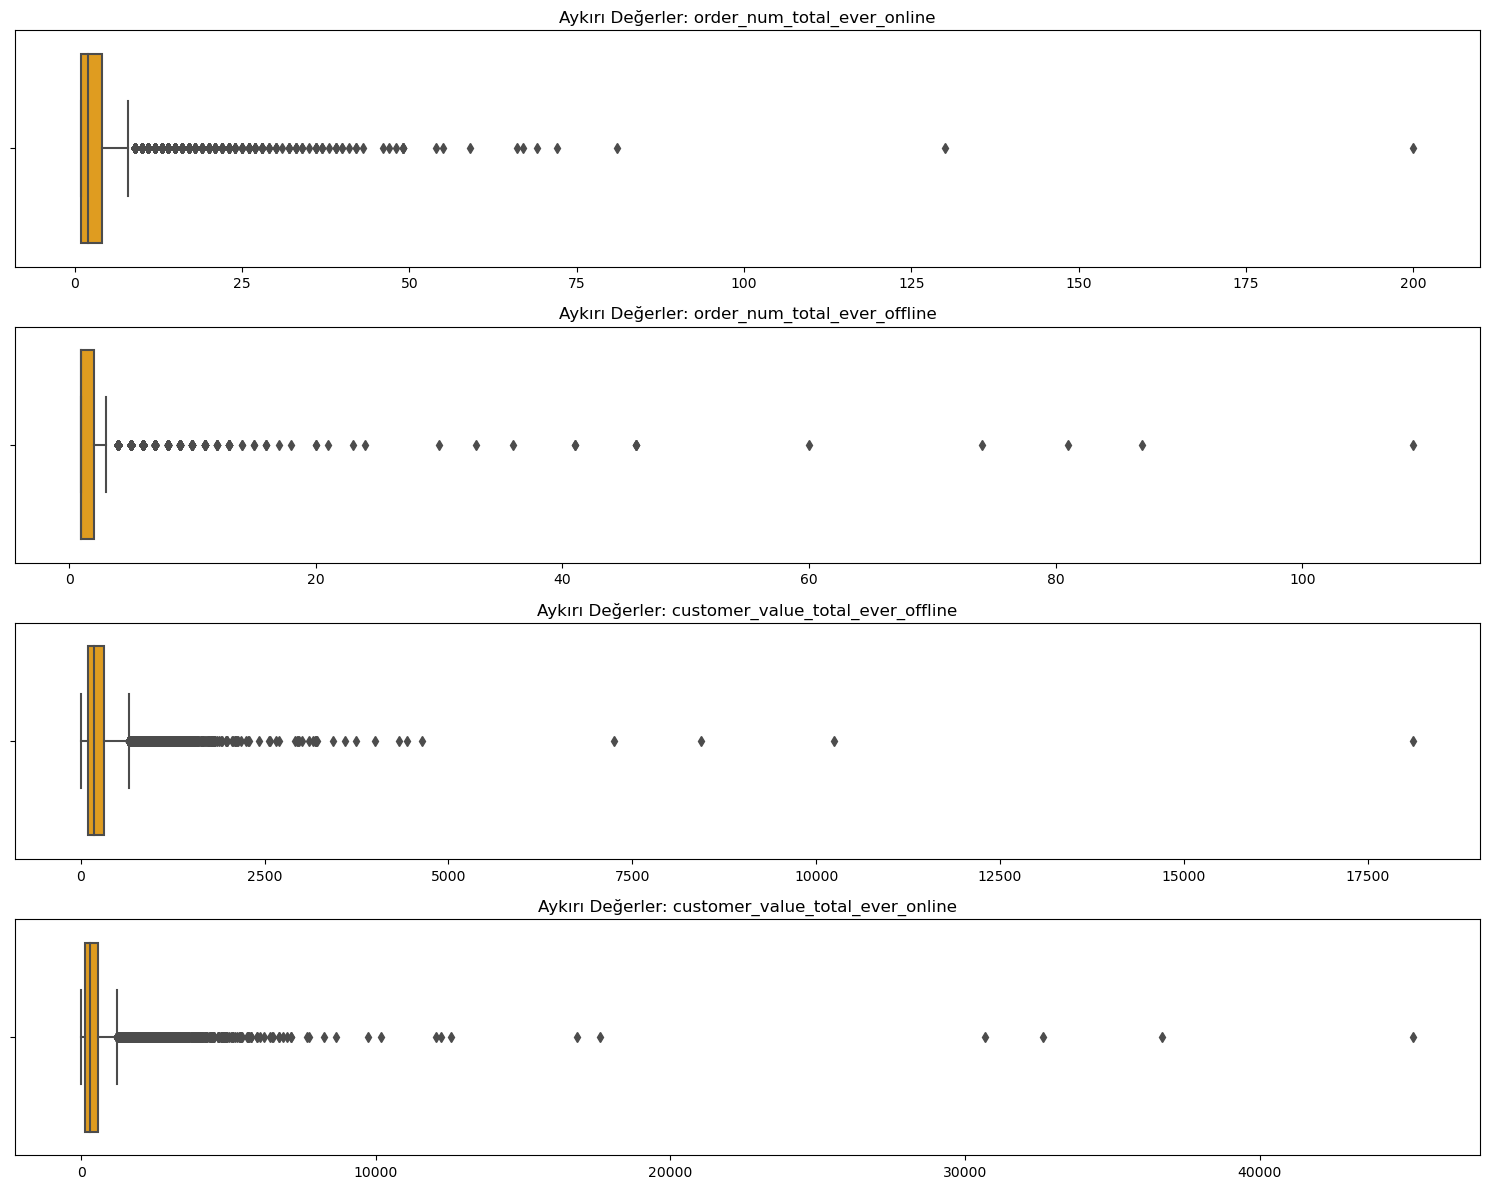

In [7]:
def explore_dataframe(df):
    """
    Veri çerçevesinin temel bilgilerini ve tüm aykırı değerlerin görselleştirilmesini sağlayan fonksiyon.
    """
    print("İlk 5 Satır:\n", df.head(), "\n" + "-"*50)
    print("Kolonlar:\n", df.columns, "\n" + "-"*50)
    print("Şekil (Satır, Sütun):\n", df.shape, "\n" + "-"*50)
    print("Açıklayıcı İstatistikler:\n", df.describe().T, "\n" + "-"*50)
    print("Eksik Veri Sayısı:\n", df.isnull().sum(), "\n" + "-"*50)
    print("Veri Bilgisi:")
    df.info()

    # Sayısal değişkenler
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns


    if len(numeric_columns) > 0:
        plt.figure(figsize=(15, len(numeric_columns) * 3))  
        for i, col in enumerate(numeric_columns):
            plt.subplot(len(numeric_columns), 1, i+1)
            sns.boxplot(x=df[col], color="orange")
            plt.title(f"Aykırı Değerler: {col}")
            plt.xlabel("")

        plt.tight_layout()
        plt.show()
    else:
        print("Aykırı değer analizi için uygun sayısal değişken bulunamadı.")

explore_dataframe(df)


### Grafiklerden görüldüğü üzere, aykırı değerlerimiz mevcut. Bu aykırı değerleri baskılayarak analizimize devam edelim.

In [8]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0)

In [9]:
columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
for col in columns:
    replace_with_thresholds(df, col)

### Her bir müşterinin toplam alışveriş sayısı ve harcamasını bulalım ve bunları bir değişkene atayalım. Değişkenlerimizden tarih ifade edenleride "date" tipine çevirelim.

In [15]:
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)
print(df.head())
print(df.info())

                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop   

  first_order_date last_order_date last_order_date_online  \
0       2020-10-30      2021-02-26             2021-02-21   
1       2017-02-08      2021-02-16             2021-02-16   
2       2019-11-27      2020-11-27             2020-11-27   
3       2021-01-06      2021-01-17             2021-01-17   
4       2019-08-03      2021-03-07             2021-03-07   

  last_order_date_offline  order_num_total_ever_online  \
0              2021-02-26                         4.00   
1              2020-01-10                        19.00   
2 

## 2) CLTV Yapısını Oluşturma

### Veri setindeki en son alışveriş yapıldığı tarihten 2 gün sonrasını analiz tarihi olarak belirleyelim.

In [16]:
df["last_order_date"].max() # 2021-05-30
analysis_date = dt.datetime(2021,6,1)

In [19]:
cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = ((df["last_order_date"] - df["first_order_date"]).dt.days) / 7
cltv_df["T_weekly"] = ((analysis_date - df["first_order_date"]).dt.days) / 7
cltv_df["frequency"] = df["order_num_total"]
cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]

cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99


### Özetle:
* Müşteri Kimliği (customer_id): Her müşteriyi tanımlayabilmek için gerekli.
* Recency (recency_cltv_weekly): Müşterinin ilk ve son siparişi arasındaki süreyi hafta cinsinden hesaplayarak, müşterinin en son ne zaman alışveriş yaptığı hakkında bilgi verir.
* Yaşam Süresi (T_weekly): Müşterinin ilk sipariş tarihinden, analiz tarihine kadar geçen süreyi hafta cinsinden ölçer. Bu, müşterinin ne kadar süredir aktif olduğunu gösterir.
* Frekans (frequency): Müşterinin toplam sipariş sayısını belirterek, alışveriş sıklığını ortaya koyar.
* Monetary (monetary_cltv_avg): Müşterinin yaptığı alışverişlerin ortalama harcamasını hesaplar; bu, sipariş sayısına bölünerek bulunur.

## 3) BG/NBD, Gamma-Gamma Modellerinin Kurulması

* Müşterilerin gelecekteki satın alma davranışlarını tahmin etmek için BG/NBD modeli oluşturulacaktır
* Bu eğitim aşaması, modelin her müşterinin gelecekteki satın alma olasılığı ve beklenen satın alma sayısını tahmin edebilmesi için gerekli parametreleri öğrenmesini sağlar.

In [21]:
# BG/NBD modelinin kurulması
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>


/Users/hasangulec/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### 3 ay içerisinde müşterilerden beklenen satın almaları tahmin edelim ve cltv_df'e  atayalım.

In [22]:
cltv_df["exp_sales_3_month"] = bgf.predict(4*3,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])
print(cltv_df)

                                customer_id  recency_cltv_weekly  T_weekly  \
0      cc294636-19f0-11eb-8d74-000d3a38a36f                17.00     30.57   
1      f431bd5a-ab7b-11e9-a2fc-000d3a38a36f               209.86    224.86   
2      69b69676-1a40-11ea-941b-000d3a38a36f                52.29     78.86   
3      1854e56c-491f-11eb-806e-000d3a38a36f                 1.57     20.86   
4      d6ea1074-f1f5-11e9-9346-000d3a38a36f                83.14     95.43   
...                                     ...                  ...       ...   
19940  727e2b6e-ddd4-11e9-a848-000d3a38a36f                41.14     88.43   
19941  25cd53d4-61bf-11ea-8dd8-000d3a38a36f                42.29     65.29   
19942  8aea4c2a-d6fc-11e9-93bc-000d3a38a36f                88.71     89.86   
19943  e50bb46c-ff30-11e9-a5e8-000d3a38a36f                98.43    113.86   
19944  740998d2-b1f7-11e9-89fa-000d3a38a36f                39.57     91.00   

       frequency  monetary_cltv_avg  exp_sales_3_month  
0     

#### 6 ay içerisinde müşterilerden beklenen satın almaları tahmin edelim ve cltv_df'e  atayalım.

In [23]:
cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])
print(cltv_df)

                                customer_id  recency_cltv_weekly  T_weekly  \
0      cc294636-19f0-11eb-8d74-000d3a38a36f                17.00     30.57   
1      f431bd5a-ab7b-11e9-a2fc-000d3a38a36f               209.86    224.86   
2      69b69676-1a40-11ea-941b-000d3a38a36f                52.29     78.86   
3      1854e56c-491f-11eb-806e-000d3a38a36f                 1.57     20.86   
4      d6ea1074-f1f5-11e9-9346-000d3a38a36f                83.14     95.43   
...                                     ...                  ...       ...   
19940  727e2b6e-ddd4-11e9-a848-000d3a38a36f                41.14     88.43   
19941  25cd53d4-61bf-11ea-8dd8-000d3a38a36f                42.29     65.29   
19942  8aea4c2a-d6fc-11e9-93bc-000d3a38a36f                88.71     89.86   
19943  e50bb46c-ff30-11e9-a5e8-000d3a38a36f                98.43    113.86   
19944  740998d2-b1f7-11e9-89fa-000d3a38a36f                39.57     91.00   

       frequency  monetary_cltv_avg  exp_sales_3_month  exp_sal

#### 3. ve 6. aydaki en çok satın alım gerçekleştirecek ilk 10 kişiyi inceleyelim.

In [27]:
print(cltv_df.sort_values("exp_sales_3_month",ascending=False)[:10])

print(cltv_df.sort_values("exp_sales_6_month",ascending=False)[:10])

                                customer_id  recency_cltv_weekly  T_weekly  \
7330   a4d534a2-5b1b-11eb-8dbd-000d3a38a36f                62.71     67.29   
15611  4a7e875e-e6ce-11ea-8f44-000d3a38a36f                39.71     40.00   
8328   1902bf80-0035-11eb-8341-000d3a38a36f                28.86     33.29   
19538  55d54d9e-8ac7-11ea-8ec0-000d3a38a36f                52.57     58.71   
14373  f00ad516-c4f4-11ea-98f7-000d3a38a36f                38.00     46.43   
10489  7af5cd16-b100-11e9-9757-000d3a38a36f               103.14    111.86   
4315   d5ef8058-a5c6-11e9-a2fc-000d3a38a36f               133.14    147.14   
6756   27310582-6362-11ea-a6dc-000d3a38a36f                62.71     64.14   
6666   53fe00d4-7b7a-11eb-960b-000d3a38a36f                 9.71     13.00   
10536  e143b6fa-d6f8-11e9-93bc-000d3a38a36f               104.57    113.43   

       frequency  monetary_cltv_avg  exp_sales_3_month  exp_sales_6_month  
7330       52.00             166.22               4.66           

* En çok satın alım gerçekleştirmesi beklenen müşteriler 3 aylık ve 6 aylık tahminlerde aynı sıralamaya çok yakın (hatta muhtemelen tamamen aynı) çıkıyor. Bunun nedeni, kısa vadede öne çıkan “en aktif” müşterilerin uzun vadede de genelde en aktif kalmalarıdır. Yani:
    * 3 ay ya da 6 ay tahmin etseniz de, en yüksek satın alma potansiyeline sahip müşteriler yine aynı kişiler oluyor. Çünkü model, yüksek frekans ve düzenli alışveriş yapan müşterileri hem kısa hem uzun dönemde “zirveye” koyuyor.
    * 6 aylık periyot, 3 aydan iki kat daha uzun olduğu için, beklenen satın alma sayısı 6 ayda doğal olarak daha yüksek tahmin ediliyor. Numerik değerler artıyor, ancak kimlerin en çok satın alacağına dair sıralama pek değişmiyor.

## 4) Gamma - Gamma Modelini uyarlayalım.

### Müşterilerin ortalama bırakacakları değeri tahminleyip bir cltv_df'e atayalım

In [28]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,0.97,1.95,193.63
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,0.98,1.97,96.67
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,0.67,1.34,120.97
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,0.70,1.40,67.32
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,0.40,0.79,114.33


### 3 ve 6 aylık CLTV hesaplayalım ve cltv_df'e ekleyelim. CLTV değeri en yüksek 20 kişiyi gözlemleyelim.

In [31]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)
cltv_df["cltv"] = cltv
cltv_df.sort_values("cltv",ascending=False)[:20]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.86,7.86,4.00,1401.80,1.09,2.19,1449.06,3327.78
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.14,13.14,11.00,758.09,1.97,3.94,767.36,3172.39
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.71,101.00,7.00,1106.47,0.72,1.44,1127.61,1708.98
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.29,74.57,16.00,501.87,1.57,3.13,506.17,1662.61
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31,166.71,1628.89
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.43,34.43,8.00,601.23,1.27,2.53,611.49,1623.81
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.29,9.43,2.00,862.69,0.79,1.59,923.68,1538.86
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56,262.07,1529.23
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17,229.61,1485.82
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.86,15.57,3.00,743.59,0.87,1.74,778.05,1423.00
